In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from time import time
import itertools
import pickle
import os.path

from Basics import Deck, test_shuffle
from win_lose import evaluate_7cards, evaluate_5cards, best_hand
from Game_Board import Test_Game

The goal of this notebook is to look at different variations in poker and whether those things matter

Initial Observations:
1. lots more ties in a 10 person game

| # Players | # of games | Winning Hands | % Possible Ties |
| - | - | - | - |
| 10 Players | 200,000 | 234,726 | 17.36%|
| 5 Players | 200,000 | 219,511 | 9.76% |
| 2 Players | 200,000 | 208,850 | 4.43%|

2. Average winning percentages:

| # Players | Avg Chance of Winning | x players |
| - | - | - |
| 10 Players | 11.74% | 17% ties |
| 5 Players | 21.95% | 10% ties |
| 2 Players | 52.21% | 4% ties |

In [14]:
winner_10p_filename = 'Data/winner_sim_200k_10p.pickle' #this is for 10p
with open(winner_10p_filename, 'rb') as handle:
    winning10p_df = pickle.load(handle)
winning10p_df['df'] = 10

In [15]:
winner_5p_filename = 'Data/winner_sim_200k_5p.pickle' #this is for 5p
with open(winner_5p_filename, 'rb') as handle:
    winning5p_df = pickle.load(handle)
winning5p_df['df'] = 5

In [16]:
winner_2p_filename = 'Data/winner_sim_200k_2p.pickle' #this is for 2p
with open(winner_2p_filename, 'rb') as handle:
    winning2p_df = pickle.load(handle)
winning2p_df['df'] = 2

In [20]:
#these two functions help me come up with some classifications
def suit_cat(x):
    if x[0] == x[1]:
        return 'same'
    else:
        return 'diff'
    
def rank_cat(x):
    max_rank = max(int(x[0]), int(x[1]))
    min_rank = min(int(x[0]), int(x[1]))
    
    if max_rank == min_rank:
        status1 = 'pair'
    elif abs(max_rank - min_rank) == 1 or (max_rank == 14 and min_rank == 2):
        status1 = '1gap'
    elif abs(max_rank - min_rank) == 2 or (max_rank == 14 and min_rank == 3):
        status1 = '2gap'
    elif abs(max_rank - min_rank) == 3 or (max_rank == 14 and min_rank == 4):
        status1 = '3gap'
    elif abs(max_rank - min_rank) == 4 or (max_rank == 14 and min_rank == 5):
        status1 = '4gap'
    else:
        status1 = '5gap+' 
        
    if max_rank >= 11:
        status2 = 'high'
    elif max_rank >= 6:
        status2 = 'mid'
    else:
        status2 = 'low'
    return status2 + ' ' + status1

In [21]:
winning_df = pd.concat([winning10p_df, winning5p_df, winning2p_df])
winning_df['suit cat'] = winning_df['whole'].apply(lambda x: [i[-1] for i in x]).apply(suit_cat)
winning_df['rank'] = winning_df['whole'].apply(lambda x: [int(i[:-1]) for i in x]).apply(sorted).apply(tuple)
winning_df['rank cat'] = winning_df['rank'].apply(rank_cat)

winning_df.head()

,player,whole,comm,combined,mess,best hand,eval,winner,round,df,suit cat,rank,rank cat
0,0,"[6♠, 4♢]","[12♠, 11♡, 5♡, 6♡, 8♡]","[6♠, 4♢, 12♠, 11♡, 5♡, 6♡, 8♡]","[((6♠, 12♠, 11♡, 6♡, 8♡), (2, 1 Pair, 6, [12, ...","(6♠, 12♠, 11♡, 6♡, 8♡)","(2, 1 Pair, 6, [12, 11, 8])",0,0,10,diff,"(4, 6)",mid 2gap
1,1,"[14♢, 10♠]","[12♠, 11♡, 5♡, 6♡, 8♡]","[14♢, 10♠, 12♠, 11♡, 5♡, 6♡, 8♡]","[((14♢, 10♠, 12♠, 11♡, 8♡), (1, High, [14, 12,...","(14♢, 10♠, 12♠, 11♡, 8♡)","(1, High, [14, 12, 11, 10, 8], 0)",0,0,10,diff,"(10, 14)",high 4gap
2,2,"[13♠, 11♣]","[12♠, 11♡, 5♡, 6♡, 8♡]","[13♠, 11♣, 12♠, 11♡, 5♡, 6♡, 8♡]","[((13♠, 11♣, 12♠, 11♡, 8♡), (2, 1 Pair, 11, [1...","(13♠, 11♣, 12♠, 11♡, 8♡)","(2, 1 Pair, 11, [13, 12, 8])",0,0,10,diff,"(11, 13)",high 2gap
3,3,"[2♢, 9♡]","[12♠, 11♡, 5♡, 6♡, 8♡]","[2♢, 9♡, 12♠, 11♡, 5♡, 6♡, 8♡]","[((9♡, 11♡, 5♡, 6♡, 8♡), (6, Flush, [11, 9, 8,...","(9♡, 11♡, 5♡, 6♡, 8♡)","(6, Flush, [11, 9, 8, 6, 5], 0)",0,0,10,diff,"(2, 9)",mid 5gap+
4,4,"[12♣, 7♠]","[12♠, 11♡, 5♡, 6♡, 8♡]","[12♣, 7♠, 12♠, 11♡, 5♡, 6♡, 8♡]","[((12♣, 7♠, 12♠, 11♡, 8♡), (2, 1 Pair, 12, [11...","(12♣, 7♠, 12♠, 11♡, 8♡)","(2, 1 Pair, 12, [11, 8, 7])",0,0,10,diff,"(7, 12)",high 5gap+


In [62]:
mydeck = Deck()
all_possible_whole = pd.DataFrame({'whole':[whole for whole in list(itertools.combinations(mydeck.order(), 2))]})
all_possible_whole['whole rank'] = all_possible_whole['whole'].apply(lambda x: [int(i[:-1]) for i in x]).apply(lambda x: sorted(x)).apply(tuple)
all_possible_whole['whole suit'] = all_possible_whole['whole'].apply(lambda x: [i[-1] for i in x]).apply(lambda x: sorted(x)).apply(tuple)
all_possible_whole['whole'] = all_possible_whole['whole'].apply(sorted).apply(tuple)
all_possible_whole['suit cat'] = all_possible_whole['whole suit'].apply(suit_cat)
all_possible_whole['rank cat'] = all_possible_whole['whole rank'].apply(rank_cat)
print(all_possible_whole.iloc[100:106])
print(all_possible_whole.shape)

         whole whole rank whole suit suit cat    rank cat
100  (13♠, 2♣)    (2, 13)     (♠, ♣)     diff  high 5gap+
101   (3♣, 4♣)     (3, 4)     (♣, ♣)     same    low 1gap
102   (3♣, 5♣)     (3, 5)     (♣, ♣)     same    low 2gap
103   (3♣, 6♣)     (3, 6)     (♣, ♣)     same    mid 3gap
104   (3♣, 7♣)     (3, 7)     (♣, ♣)     same    mid 4gap
105   (3♣, 8♣)     (3, 8)     (♣, ♣)     same   mid 5gap+
(1326, 5)


In [49]:
winning_df_summary = winning_df[winning_df['winner'] == 1][['whole', 'df']]
winning_df_summary['whole'] = winning_df_summary['whole'].apply(sorted).apply(tuple)
winning_df_summary = winning_df_summary.groupby(['whole', 'df'])['whole'].count().to_frame()
winning_df_summary.rename(columns = {'whole': 'winning counts'}, inplace = True)
winning_df_summary.reset_index(inplace = True)
winning_df_summary.head()

In [57]:
whole_df = winning_df[['whole', 'df']]
whole_df['whole'] = whole_df['whole'].apply(sorted).apply(tuple)
whole_df = whole_df.groupby(['whole', 'df'])['whole'].count().to_frame()
whole_df.rename(columns = {'whole': 'whole counts'}, inplace = True)
whole_df.reset_index(inplace = True)
whole_df.head()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,whole,df,whole counts
0,"(10♠, 10♡)",2,311
1,"(10♠, 10♡)",5,714
2,"(10♠, 10♡)",10,1497
3,"(10♠, 10♢)",2,293
4,"(10♠, 10♢)",5,788


In [63]:
all_possible_whole = all_possible_whole.merge(whole_df, how = 'outer', left_on = 'whole', right_on = 'whole')
print(all_possible_whole.head())
print(all_possible_whole.shape)

       whole whole rank whole suit suit cat   rank cat  df  whole counts
0  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap   2           322
1  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap   5           706
2  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap  10          1569
3  (14♣, 3♣)    (3, 14)     (♣, ♣)     same  high 2gap   2           322
4  (14♣, 3♣)    (3, 14)     (♣, ♣)     same  high 2gap   5           772
(3978, 7)


In [64]:
all_possible_whole = all_possible_whole.merge(winning_df_summary, how = 'outer', left_on = ['whole', 'df'], right_on = ['whole', 'df'])
print(all_possible_whole.head())
print(all_possible_whole.shape)

       whole whole rank whole suit suit cat   rank cat  df  whole counts  \
0  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap   2           322   
1  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap   5           706   
2  (14♣, 2♣)    (2, 14)     (♣, ♣)     same  high 1gap  10          1569   
3  (14♣, 3♣)    (3, 14)     (♣, ♣)     same  high 2gap   2           322   
4  (14♣, 3♣)    (3, 14)     (♣, ♣)     same  high 2gap   5           772   

   winning counts  
0             189  
1             200  
2             219  
3             188  
4             200  
(3978, 8)


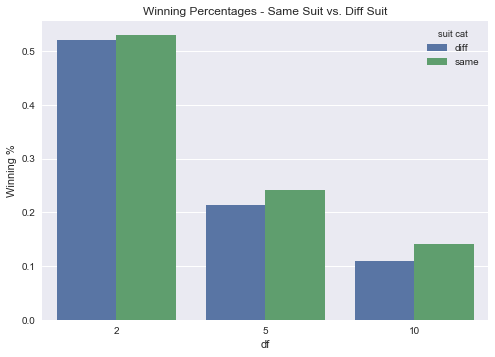

,df,suit cat,whole counts,winning counts,whole occurance,whole winning %
0,2,diff,305891,158999,0.764728,0.519790
1,2,same,94109,49851,0.235272,0.529716
2,5,diff,763679,162547,0.763679,0.212847
3,5,same,236321,56964,0.236321,0.241045
4,10,diff,1529655,167993,0.764827,0.109824
5,10,same,470345,66733,0.235173,0.141881


In [75]:
#groupby and compare suit categories to see if there's a clear difference in winning percentage. Plot if necessary
hands = 200000

temp = all_possible_whole.groupby(['df', 'suit cat'])[['whole counts', 'winning counts']].sum()
temp.reset_index(inplace = True)
temp['whole occurance'] = temp['whole counts'] / hands / temp['df']
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']


sns.barplot(data = temp, x = 'df', y = 'whole winning %', hue = 'suit cat')
plt.ylabel('Winning %')
plt.title('Winning Percentages - Same Suit vs. Diff Suit')
plt.show()

temp.head(10)

In [13]:
#groupby and compare suit categories to see if there's a clear difference in winning percentage. Plot if necessary
temp = all_possible_whole.groupby('suit cat')[['suit cat', 'whole counts', 'winning counts']].sum()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']
temp.sort_index(ascending = False, inplace = True)

plt.rcParams['figure.figsize'] = [20, 10]
temp['whole winning %'].plot(kind = 'bar')
plt.ylabel('Winning %')
plt.title('Winning Percentages - Same Suit vs. Diff Suit')
plt.show()
temp.head()

,player,whole,comm,combined,mess,best hand,eval,winner,round
0,0,"[6♠, 4♢]","[12♠, 11♡, 5♡, 6♡, 8♡]","[6♠, 4♢, 12♠, 11♡, 5♡, 6♡, 8♡]","[((6♠, 12♠, 11♡, 6♡, 8♡), (2, 1 Pair, 6, [12, ...","(6♠, 12♠, 11♡, 6♡, 8♡)","(2, 1 Pair, 6, [12, 11, 8])",0,0
1,1,"[14♢, 10♠]","[12♠, 11♡, 5♡, 6♡, 8♡]","[14♢, 10♠, 12♠, 11♡, 5♡, 6♡, 8♡]","[((14♢, 10♠, 12♠, 11♡, 8♡), (1, High, [14, 12,...","(14♢, 10♠, 12♠, 11♡, 8♡)","(1, High, [14, 12, 11, 10, 8], 0)",0,0
2,2,"[13♠, 11♣]","[12♠, 11♡, 5♡, 6♡, 8♡]","[13♠, 11♣, 12♠, 11♡, 5♡, 6♡, 8♡]","[((13♠, 11♣, 12♠, 11♡, 8♡), (2, 1 Pair, 11, [1...","(13♠, 11♣, 12♠, 11♡, 8♡)","(2, 1 Pair, 11, [13, 12, 8])",0,0
3,3,"[2♢, 9♡]","[12♠, 11♡, 5♡, 6♡, 8♡]","[2♢, 9♡, 12♠, 11♡, 5♡, 6♡, 8♡]","[((9♡, 11♡, 5♡, 6♡, 8♡), (6, Flush, [11, 9, 8,...","(9♡, 11♡, 5♡, 6♡, 8♡)","(6, Flush, [11, 9, 8, 6, 5], 0)",0,0
4,4,"[12♣, 7♠]","[12♠, 11♡, 5♡, 6♡, 8♡]","[12♣, 7♠, 12♠, 11♡, 5♡, 6♡, 8♡]","[((12♣, 7♠, 12♠, 11♡, 8♡), (2, 1 Pair, 12, [11...","(12♣, 7♠, 12♠, 11♡, 8♡)","(2, 1 Pair, 12, [11, 8, 7])",0,0


Turns out that for a 2 person game, suits doesn't make that much of a difference: